In [1]:
# Test GPU on machine
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/home/chanjunshern/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[22. 28.]
 [49. 64.]]


In [1]:
import numpy as np
import pianoroll_utils
from matplotlib import pyplot as plt
import pypianoroll

In [87]:
input_pianoroll = np.load('recorded_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
comp_pianoroll = np.load('generated_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
test = generated_pianoroll
# Plot comparison
fig, ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)
ax.set_title('Input')
pypianoroll.plot_pianoroll(ax, test, beat_resolution=24)
fig.tight_layout()

# Play comparison
# pianoroll_utils.playPianoroll(test)

NameError: name 'generated_pianoroll' is not defined

In [29]:
import mido
from mido import Message, MidiFile, MidiTrack
import subprocess

COMP_CHANNEL = 5
beats_per_minute = 60
beats_per_bar = 4
ticks_per_beat = 24
seconds_per_tick = 60. / beats_per_minute / ticks_per_beat

def play_midi_events(events):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    # Loop through every tick in every beat
    for beat in range(beats_per_bar):
        # Play recorded messages and wait at each tick
        for tick in range(ticks_per_beat):
            current_tick = beat*ticks_per_beat + tick
            for msg in events[current_tick]:
                track.append(msg.copy(channel=COMP_CHANNEL, time=0))
            # This effectively acts as a time.sleep for 1 tick
            track.append(Message('note_off', note=0, velocity=0, time=16))
    FILEPATH = '/tmp/tmp_.midi' # For Linux
    mid.save(FILEPATH)
    return_code = subprocess.call("timidity " + FILEPATH, shell=True)
    return

def pianoroll_2_events(pianoroll):
    """
    Takes an input pianoroll of shape (NUM_PITCHES, NUM_TICKS) 
    and returns a list of quantized events
    "Adjacent nonzero values of the same pitch will be considered a 
    single note with their mean as its velocity.", as per pypianoroll.
    https://github.com/salu133445/pypianoroll/blob/master/pypianoroll/multitrack.py#L1171
    """
    assert pianoroll.shape == (128, 96)
    events = [[] for _ in range(96)] # Each tick gets a list to store events
    for pitch_index in range(pianoroll.shape[0]):
        prev_velocity = 0
        velocity = 0
        
        note_events = [] # List of note on-offs (on_tick, off_tick)
        for tick_index in range(pianoroll.shape[1]):
            # Update
            prev_velocity = velocity
            velocity = int(pianoroll[pitch_index, tick_index])
            # On
            if velocity > 0 and prev_velocity == 0:
                note_events.append([tick_index, -1])
            # Off
            elif velocity == 0 and prev_velocity > 0:
                note_events[-1][1] = tick_index
        
        for on_index, off_index in note_events:
            if off_index != -1:
                velocity = int(np.mean(pianoroll[pitch_index, on_index:off_index]))
                on_msg = mido.Message('note_on', note=pitch_index, velocity=velocity, time=0)
                events[on_index].append(on_msg)
                off_msg = mido.Message('note_off', note=pitch_index, velocity=velocity, time=0)
                events[off_index].append(off_msg)
            else:
                velocity = int(np.mean(pianoroll[pitch_index, on_index:]))
                on_msg = mido.Message('note_on', note=pitch_index, velocity=velocity, time=0)
                events[on_index].append(on_msg)
            
    return events

In [33]:
def pianoroll_2_events(pianoroll):
    """
    Takes an input pianoroll of shape (NUM_PITCHES, NUM_TICKS) 
    and returns a list of quantized events
    "Adjacent nonzero values of the same pitch will be considered a 
    single note with their mean as its velocity.", as per pypianoroll.
    https://github.com/salu133445/pypianoroll/blob/master/pypianoroll/multitrack.py#L1171
    """
    assert pianoroll.shape == (128, 96)
    pianoroll = pianoroll.T
    
    events = [[] for _ in range(96)] # Each tick gets a list to store events
    clipped = pianoroll.astype(int)
    binarized = clipped.astype(bool)
    padded = np.pad(binarized, ((1, 1), (0, 0)), 'constant')
    diff = np.diff(padded.astype(int), axis=0)

    for pitch in range(128):
        note_ons = np.nonzero(diff[:, pitch] > 0)[0]
        note_offs = np.nonzero(diff[:, pitch] < 0)[0]
        for idx, note_on in enumerate(note_ons):
            velocity = np.mean(clipped[note_on:note_offs[idx], pitch])
            # Create message events
            on_msg = mido.Message('note_on', note=pitch, velocity=int(velocity), time=0)
            events[note_ons[idx]].append(on_msg)
            if note_offs[idx] < 96:
                off_msg = mido.Message('note_on', note=pitch, velocity=0, time=0)
                events[note_offs[idx]].append(off_msg)
    return events

In [3]:
from keras.models import load_model
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

Using TensorFlow backend.


In [4]:
from keras.models import Model
# Normalize input_pianoroll
input_pianoroll = np.load('recorded_pianoroll.npy')
input_pianoroll = input_pianoroll / 127.
# Get encoding of the input
input_pianoroll = input_pianoroll.reshape(1, 128, 96, 1)
autoencoder_output = autoencoder.predict(input_pianoroll) # (1, 128, 96, 1)
assert autoencoder_output.shape == (1, 128, 96, 1)
print "Getting autoencoder stuff", autoencoder_output.shape
# print np.sum(input_pianoroll - autoencoder_output)
print np.sum(input_pianoroll)
print np.amin(autoencoder_output)
# output_pianoroll = autoencoder_output[0].reshape(128, 96)

Getting autoencoder stuff (1, 128, 96, 1)
55.90551181102363
0.0


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.4705973  20.77994    24.45203     0.877367    0.          3.9844081
  6.5914383   5.171249    1.4545087   2.5562441   3.8582234   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.03607762  9.261589   13.108125   16.930813   20.213509   17.428322
 17.123474    3.6582694   3.8401468   0.          0.          0.90885544
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.

0

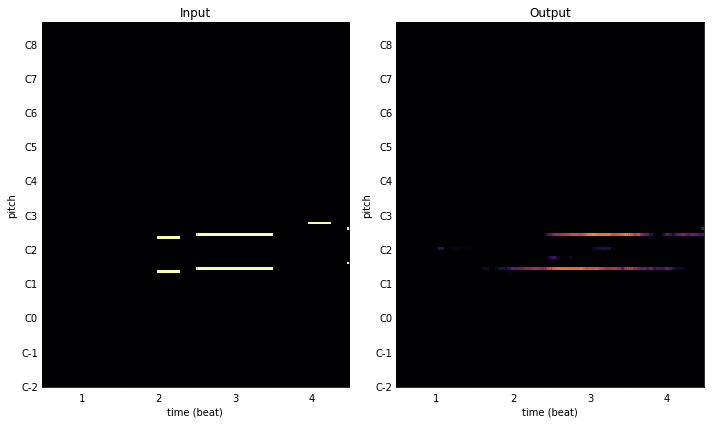

In [46]:
import pianoroll_utils

sample_input = input_pianoroll.reshape(128,96).swapaxes(0,1).reshape(96, 128) * 127
sample_output = autoencoder_output[0].swapaxes(0,1).reshape(96, 128) * 127
print sample_output[:,48]
# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_output)

In [49]:
input_pianoroll = np.load('recorded_pianoroll.npy')
print input_pianoroll.shape

print("")
print("Input")
play_midi_events(pianoroll_2_events(input_pianoroll))

print("")
print("Output")
play_midi_events(pianoroll_2_events(autoencoder_output.reshape(128,96) * 127))

(128, 96)

Input

Output


In [48]:
# print np.amax(autoencoder_output)
output = autoencoder_output.reshape(128,96) / np.amax(autoencoder_output) * 127
print output[48,:]

0.76522815
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  4.5353756  27.15522    31.953907    1.146543    0.          5.206824
  8.61369     6.757787    1.9007516   3.3404996   5.041926    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.04714623 12.103043   17.129694   22.125185   26.415009   22.775328
 22.376951    4.7806253   5.0183034   0.          0.          1.1876922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        

note_on channel=0 note=48 velocity=117 time=0.25
note_on channel=0 note=48 velocity=0 time=0.0840909090909
note_on channel=0 note=48 velocity=127 time=0.0204545454545
note_on channel=0 note=48 velocity=0 time=0.125
note_on channel=0 note=41 velocity=126 time=0.0613636363636
note_on channel=0 note=40 velocity=127 time=0.188636363636
note_on channel=0 note=40 velocity=0 time=0.0409090909091
note_on channel=0 note=53 velocity=127 time=0.188636363636
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.104545454545
note_on channel=0 note=45 velocity=127 time=0.0204545454545
note_on channel=0 note=45 velocity=0 time=0.0613636363636
note_on channel=0 note=45 velocity=80 time=0.0431818181818
note_on channel=0 note=45 velocity=0 time=0.0409090909091
note_on channel=0 note=48 velocity=113 time=0
note_on channel=0 note=48 velocity=0 time=0.188636363636
note_on channel=0 note=48 velocity=90 time=0.0409090909091
note_on channel=0 note=48 velocity=0 time=0.0204545454545
note_on channel=0 note=53 velocity=0 time=0.188636363636
note_on channel=0 note=53 velocity=127 time=0.0409090909091
note_on channel=0 note=41 velocity=0 time=0.145454545455
note_on channel=0 note=55 velocity=127 time=0.104545454545
note_on channel=0 note=53 velocity=0 time=0.0204545454545
note_on channel=0 note=55 velocity=0 time=0

note_on channel=5 note=48 velocity=15 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=48 velocity=3 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=41 velocity=8 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=41 velocity=50 time=0
note_on channel=5 note=40 velocity=3 time=0
note_on channel=5 note=40 velocity=0 time=0
note_on channel=5 note=53 velocity=66 time=0
note_on channel=5 note=45 velocity=14 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=4 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=45 velocity=2 time=0
note_on channel=5 note=45 velocity=0 time=0
note_on channel=5 note=48 velocity=12 time=0
note_on channel=5 note=48 velocity=0 time=0
note_on channel=5 note=53 velocity=0 time=0
note_on channel=5 note=53 velocity=32 time=0
note_on channel=5 note=41 velocity=0 time=0
note_on channel=5 note=55 velocity=29 time=0